# Jet Tagging with **Conv2D** 


### Date: Jun 20, 2021 
### Shivam Verma
#### Research Scholar, Dept. of Physics, RKMVERI

**Objective**: Jet identification task using a Conv2D multiclass classifier.

**Problem**: The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on a jet image, i.e., a 2D histogram of the transverse momentum ($p_T$) deposited in each of 100x100
bins of a square window of the ($\eta$, $\phi$) plane, centered along the jet axis.

In [3]:
import h5py          #To read the data file
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
# kera packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, Dropout, Flatten
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

# Preparating the training and validation data

In [ ]:
! git clone https://github.com/shivamv1/RKM_MLS_proj.git

In [2]:
inputDir = "RKM_MLS_proj/Data/JetDataset"
! ls RKM_MLS_proj/Data/JetDataset/

ls: cannot access 'RKM_MLS_proj/Data/JetDataset/': No such file or directory


In [5]:
target = np.array([])
jetImage = np.array([])
datafiles = ['%s/jetImage_7_100p_30000_40000.h5' %inputDir,
           '%s/jetImage_7_100p_60000_70000.h5' %inputDir,
            '%s/jetImage_7_100p_50000_60000.h5' %inputDir,
            '%s/jetImage_7_100p_10000_20000.h5' %inputDir,
            '%s/jetImage_7_100p_0_10000.h5' %inputDir]
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myjetImage = np.array(f.get("jetImage"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetImage = np.concatenate([jetImage, myjetImage], axis=0) if jetImage.size else myjetImage
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, jetImage.shape)

Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 100)


# Spliting Data Train:Test = 75:25

In [6]:
X_train, X_val, y_train, y_val = train_test_split(jetImage, target, test_size=0.25)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(37500, 100, 100) (12500, 100, 100) (37500, 5) (12500, 5)


Reshaping the training dataset since in keras  images are representable as $n \times m \times k$ tensors, where $n \times m$ are the pixel dimenions and $k$ is the number of channels (e.g., 1 in a black $\&$ while image, 3 for an RGB image). In our case, $k=1$. To comply to this, we add the channel index by reshaping the image dataset

In [7]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetImage, target

(37500, 100, 100, 1) (12500, 100, 100, 1) (37500, 5) (12500, 5)


# Model building

In [8]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
dropoutRate = 0.25

In [9]:
image_shape = (img_rows, img_cols, 1)
#
inputImage = Input(shape=(image_shape))
x = Conv2D(10, kernel_size=(5,5), data_format="channels_last", strides=(1, 1), padding="same")(inputImage)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (5,5))(x)
x = Dropout(dropoutRate)(x)
#
x = Conv2D(7, kernel_size=(3,3), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (3,3))(x)
x = Dropout(dropoutRate)(x)
#
x = Flatten()(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
#
model = Model(inputs=inputImage, outputs=output)

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 10)      260       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 10)      40        
_________________________________________________________________
activation (Activation)      (None, 100, 100, 10)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 10)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 20, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 7)         637   

# Training the model

In [11]:
batch_size = 128
n_epochs = 200

In [12]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
                TerminateOnNaN()])

Epoch 1/200
293/293 - 8s - loss: 1.4770 - val_loss: 1.2869
Epoch 2/200
293/293 - 4s - loss: 1.3129 - val_loss: 1.2252
Epoch 3/200
293/293 - 4s - loss: 1.2585 - val_loss: 1.1905
Epoch 4/200
293/293 - 4s - loss: 1.2223 - val_loss: 1.1667
Epoch 5/200
293/293 - 5s - loss: 1.1955 - val_loss: 1.1343
Epoch 6/200
293/293 - 5s - loss: 1.1708 - val_loss: 1.1128
Epoch 7/200
293/293 - 5s - loss: 1.1603 - val_loss: 1.0981
Epoch 8/200
293/293 - 5s - loss: 1.1524 - val_loss: 1.0939
Epoch 9/200
293/293 - 5s - loss: 1.1363 - val_loss: 1.0786
Epoch 10/200
293/293 - 5s - loss: 1.1315 - val_loss: 1.0749
Epoch 11/200
293/293 - 5s - loss: 1.1255 - val_loss: 1.0627
Epoch 12/200
293/293 - 5s - loss: 1.1175 - val_loss: 1.0712
Epoch 13/200
293/293 - 5s - loss: 1.1146 - val_loss: 1.0562
Epoch 14/200
293/293 - 5s - loss: 1.1094 - val_loss: 1.0573
Epoch 15/200
293/293 - 5s - loss: 1.1050 - val_loss: 1.0454
Epoch 16/200
293/293 - 4s - loss: 1.0975 - val_loss: 1.0447
Epoch 17/200
293/293 - 4s - loss: 1.0961 - val_lo

# Train and validation plot

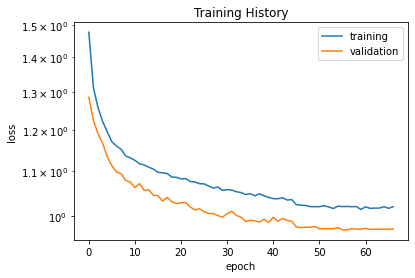

In [13]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# ROC Curves to understand how well the model was trained

In [14]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

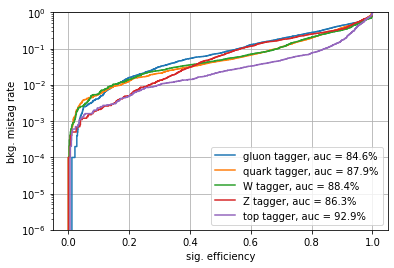

In [15]:
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()